# Manning liveProject: Deploy DL Model on Web & Mobile Using TensorFlow
---
## Milestone 1: Build an image classifier
* ResNet50
* MobileNetV2
* MobileNetV2: fine-tuned

## Solutions Notebook
---
#### Date updated:  20-Sep-2021
#### Author:  Nidhin Pattaniyil & Reshama Shaikh


In [1]:
from datetime import date
from datetime import datetime

current_date = date.today()
print("Today's date:", current_date)

Today's date: 2021-09-27


In [2]:
now1 = datetime.now()

start_time = now1.strftime("%H:%M:%S")
print("Start Time =", start_time)

Start Time = 11:06:46


In [3]:
# run this once (each session) if `watermark` library is not loaded, then comment out
!pip install watermark tensorflow==2.3.*

     |████████████████████████████████| 320.6 MB 48 kB/s 
     |████████████████████████████████| 2.9 MB 16.5 MB/s 
     |████████████████████████████████| 20.1 MB 283 kB/s 
     |████████████████████████████████| 459 kB 71.2 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.1
    Uninstalling importlib-metadata-4.8.1:
      Successfully uninstalled importlib-metadata-4.8.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gas

In [4]:
# import libraries
#import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from pprint import pprint


In [5]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
import tensorflow as tf
import pathlib
import tensorflow_hub as hub

In [7]:
import watermark
%load_ext watermark
#%reload_ext watermark

In [8]:
# see version of system, python and libraries
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Git hash: 

requests      : 2.23.0
json          : 2.0.9
numpy         : 1.18.5
matplotlib    : 3.2.2
pathlib       : 1.0.1
tensorflow_hub: 0.12.0
tensorflow    : 2.3.4
watermark     : 2.2.0
IPython       : 5.5.0
PIL           : 7.1.2



In [9]:
tf.__version__


'2.3.4'

# Running GPU on Colab
Ensure that GPU is running on this Colab notebook by following below steps.
1. Colab Menu: Select "Runtime"
2. "Change runtime type"
3. Select "Hardware Accelerator" = GPU
4. Save

In [10]:
# confirm that GPU is running
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Setup Project Folder

In [12]:
!pwd

/content


In [13]:
!ls -lF

total 4
drwxr-xr-x 1 root root 4096 Sep 16 13:40 sample_data/


In [14]:
PROJECT_NAME = "project_food_dl"

In [15]:
# create a sub-directory for the data
# run this once and comment out
!mkdir -p {PROJECT_NAME}

In [16]:
!ls -lF

total 8
drwxr-xr-x 2 root root 4096 Sep 27 11:07 project_food_dl/
drwxr-xr-x 1 root root 4096 Sep 16 13:40 sample_data/


In [17]:
!ls -lF {PROJECT_NAME}

total 0


In [18]:
# remove log files from models
!rm -rf {PROJECT_NAME}/artifacts


In [19]:
!rm {PROJECT_NAME}/data/food-101.tar.gz

rm: cannot remove 'project_food_dl/data/food-101.tar.gz': No such file or directory


In [20]:
!rm artifacts.zip

rm: cannot remove 'artifacts.zip': No such file or directory


In [21]:
# create a sub-directory for data
!mkdir -p {PROJECT_NAME}/data

In [22]:
!ls {PROJECT_NAME} -lF

total 4
drwxr-xr-x 2 root root 4096 Sep 27 11:07 data/


Artifacts is common ML term used to describe the output created by the training process.

The output could be a fully trained model, a model checkpoint (for resuming training later), or simply a file created during the training process such as an image generated while training a Generative Adversarial Network (GAN).  
In the case of a Deep Learning model, the model artifacts are the trained weights stored in a binary format.


In [23]:
# create a sub-directory for artifacts
!mkdir -p {PROJECT_NAME}/artifacts

In [24]:
!ls {PROJECT_NAME} -lF

total 8
drwxr-xr-x 2 root root 4096 Sep 27 11:07 artifacts/
drwxr-xr-x 2 root root 4096 Sep 27 11:07 data/


# Get Data

In [25]:
# [internal]
# Reshama can use in Collab (to save time)
#!wget https://storage.googleapis.com/np-training-public/datasets/food/food-101.tar.gz -P {PROJECT_NAME}/data
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -P {PROJECT_NAME}/data
  

--2021-09-27 11:07:13--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2021-09-27 11:07:13--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘project_food_dl/data/food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  10.4MB/s    in 4m 47s  

2021-09-27 11:12:01 (16.6 MB/s) - ‘project_food_dl/data/food-101.tar.gz’ saved [4996278331/4996278331]



In [26]:
# load the data
# run this once each session and comment out
# this takes about 8 minutes
#!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -P {PROJECT_NAME}/data

In [27]:
# unpack the data
# run only once, then comment out 

!tar xzf {PROJECT_NAME}/data/food-101.tar.gz -C {PROJECT_NAME}/data

In [28]:
!ls {PROJECT_NAME} -lF

total 8
drwxr-xr-x 2 root root 4096 Sep 27 11:07 artifacts/
drwxr-xr-x 3 root root 4096 Sep 27 11:12 data/


In [29]:
DATA_DIR = str(PROJECT_NAME)+"/data/food-101/images"
DATA_DIR = pathlib.Path(DATA_DIR)

In [30]:
DATA_DIR


PosixPath('project_food_dl/data/food-101/images')

# Look at dataset

In [31]:
# look at folder names
!ls {DATA_DIR} | head -5

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare


In [32]:
# look at first five images in first image folder
!ls {DATA_DIR}/apple_pie | head -5

1005649.jpg
1011328.jpg
101251.jpg
1014775.jpg
1026328.jpg


In [33]:
# find out how many total images there are in database
image_count = len(list(DATA_DIR.glob('*/*.jpg')))
image_count

101000

In [34]:
# find out how many different classes there are
ALL_CLASS_NAMES = sorted(np.array([item.name for item in DATA_DIR.glob('*')]))
print(len(ALL_CLASS_NAMES))

101


In [35]:
ALL_CLASS_NAMES[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# Use Subset of Data
(to speed up training)

In [36]:
# Use full dataset (all classes)
subset = len(ALL_CLASS_NAMES)
subset

101

In [37]:
# use subset of classes
# NOTE: if subset=102, we are using the full dataset
start=0
subset = 102
#subset = 3

In [38]:
USE_CLASS_NAMES = ALL_CLASS_NAMES[start:start+subset]
print(len(USE_CLASS_NAMES))
print("first few classes: ")
pprint(USE_CLASS_NAMES[:7])

101
first few classes: 
['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets']


In [39]:
# let's examine one class
class1 = USE_CLASS_NAMES[0]
class1

'apple_pie'

# Save classes as classes.json

We want to save classes as a `*.json` file, so it will look like:
```json
["ceviche", "cheese_plate", "cheesecake", "chicken_curry", "chicken_quesadilla", "chicken_wings", "chocolate_cake", "chocolate_mousse", "churros", "clam_chowder"]
```

#### example of `txt` file
```text
ceviche
cheese_plate
cheesecake
...
```



In [40]:
# with open(f"{PROJECT_NAME}/artifacts/classes.txt",'w') as f:
#   f.write('\n'.join(USE_CLASS_NAMES))

# with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
#   json.dump(USE_CLASS_NAMES, f)

In [41]:
# with open(f"{PROJECT_NAME}/artifacts/classes.json",'r') as f:
#   json.dump(USE_CLASS_NAMES, f)

# Look at Images

Image Size (w, h):  511 , 512


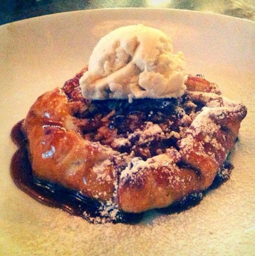

Image Size (w, h):  512 , 512


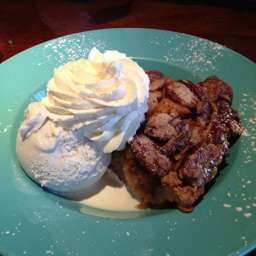

In [42]:
images = list(DATA_DIR.glob(f'{class1}/*'))

for image_path in images[:2]:
    # resize image
    im = Image.open(str(image_path))
    w, h = im.size
    print('Image Size (w, h): ', w, ",",  h)
    percent_resize = 0.5
    im = im.resize((int(w*percent_resize), int(h*percent_resize)))
    display.display(im)

# Setup for Training Model



The ImageDataGenerator is used to create training and validation splits. It also has several builtin image preprocessing transformations.

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [43]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

print("Number of classes we are training: " ,len(USE_CLASS_NAMES))
print("\nList of classes")  
list(USE_CLASS_NAMES)[:10]

Number of classes we are training:  101

List of classes


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [44]:
def get_image_data_generator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input ):
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocessing_function
  )



  # create a data generator object with options (location of images, batch size, option to shuffle, etc)
  image_data_gen = image_generator.flow_from_directory(
      directory=str(DATA_DIR),
      batch_size=BATCH_SIZE,
      shuffle=True,
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      classes = list(USE_CLASS_NAMES)
      )

  return image_data_gen

In [45]:
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)


Found 101000 images belonging to 101 classes.


# Save list of classes

In [46]:
image_data_gen.num_classes


101

In [47]:
image_data_gen.class_indices.keys

<function dict.keys>

In [48]:
image_data_gen.class_indices.keys()

dict_keys(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons',

In [49]:
list_of_classes = list(image_data_gen.class_indices.keys())

In [50]:
list_of_classes[:15]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake']

In [51]:
with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
  json.dump(list_of_classes, f)

In [52]:
def load_image(path:str) :
    img = Image.open(path)
    img = np.array(img)/255.0
    return img

In [53]:
!ls -lh {DATA_DIR}/{class1}/ | head -6

total 49M
-rw-r--r-- 1 3156 320  42K Sep 21  2013 1005649.jpg
-rw-r--r-- 1 3156 320  40K Sep 21  2013 1011328.jpg
-rw-r--r-- 1 3156 320  34K Sep 21  2013 101251.jpg
-rw-r--r-- 1 3156 320  47K Sep 21  2013 1014775.jpg
-rw-r--r-- 1 3156 320  58K Sep 21  2013 1026328.jpg


In [54]:
#load_image(f"{data_dir}/{class1}/1005649.jpg").shape

In [55]:
#plt.imshow(load_image(f"{data_dir}/{class1}/1005649.jpg"))

In [56]:
#?plt.imshow

In [57]:
#?tf.keras.utils.normalize

In [58]:
# does some pre-processing (built into image generator)
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      print(im.size)

      plt.imshow(image_batch[n]) # norm=(-1,1)
      plt.title(USE_CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [59]:
# ! this code not working  (ask Nidhin)

image_batch, label_batch = next(image_data_gen)
#show_batch(image_batch, label_batch)


# Model Architectures

In [60]:
# define dictionary
classifier={}


In [61]:
model_name = ['VGG19','ResNet50','MobileNetV2']
model_name


['VGG19', 'ResNet50', 'MobileNetV2']

In [62]:
model_name[0]

'VGG19'

In [63]:
#classifier[model_name[0]]

### Model 1: VGG19

In [64]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

# Use VGG19 pretrained on ImageNet
base_layers = tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE+(3,) )

# Add new layers to be finetuned
# The last layer, is the classification layer and should match the number of classes in the dataset. The activation should be softmax 
clf = tf.keras.Sequential([
    base_layers
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')
    , tf.keras.layers.Dense(image_data_gen.num_classes , name='classification', activation='softmax')
])

80142336/80134624 [==============================] - 1s 0us/step


In [65]:
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 20,653,221
Trainable params: 20,653,221
Non-trainable params: 0
_________________________________________________________________


In [66]:
# freezes the base layers
base_layers.trainable = False

In [67]:
# notice that after freezing the base layers, the non trainable params are equal to the number of parameters in the base layer 
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 20,653,221
Trainable params: 628,837
Non-trainable params: 20,024,384
_________________________________________________________________


In [68]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_VGG19.log"))
]

In [69]:
# Set the model to use Adam optimizer , cross entropy loss, and track accuracy.
# Since the dataset has multiple classes, we are using cross entropy loss.
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

In [70]:
# train the model for 5 epochs
%%time
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
history = clf.fit(image_data_gen
                        ,epochs=5
                        ,workers=8 
                        ,callbacks=callbacks
                        )

Found 101000 images belonging to 101 classes.
Epoch 1/5
3157/3157 [==============================] - 414s 131ms/step - loss: 2.2618 - acc: 0.4535
Epoch 2/5
3157/3157 [==============================] - 403s 128ms/step - loss: 1.8350 - acc: 0.5330
Epoch 3/5
3157/3157 [==============================] - 399s 126ms/step - loss: 1.7211 - acc: 0.5583
Epoch 4/5
3157/3157 [==============================] - 398s 126ms/step - loss: 1.6418 - acc: 0.5757
Epoch 5/5
3157/3157 [==============================] - 397s 126ms/step - loss: 1.5768 - acc: 0.5921
CPU times: user 59min 19s, sys: 2min 4s, total: 1h 1min 23s
Wall time: 33min 45s


In [71]:
export_path = str(PROJECT_NAME)+"/artifacts/model_VGG19.h5"
export_path
clf.save(export_path, save_format='h5')

### Model 2:  ResNet50

In [72]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

classifier['ResNet50'] = tf.keras.Sequential([
    #hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,) , name='pretrained')
    tf.keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=IMAGE_SHAPE+(3,) )
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')
    ,tf.keras.layers.Dense(image_data_gen.num_classes , name='classification', activation='softmax')

    
])

94773248/94765736 [==============================] - 1s 0us/step


In [73]:
clf = classifier['ResNet50']

In [74]:
clf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 25,789,413
Trainable params: 25,736,293
Non-trainable params: 53,120
_________________________________________________________________


In [75]:
clf.layers[0].trainable = False


In [76]:
clf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 25,789,413
Trainable params: 2,201,701
Non-trainable params: 23,587,712
_________________________________________________________________


In [77]:
?tf.keras.optimizers.Adam

In [78]:
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

In [79]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_ResNet50.log"))
]

#### Model results

In [80]:
%%time
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

history = clf.fit(image_data_gen
                        ,epochs=5
                        ,workers=8 
                        ,callbacks=callbacks
                        )

Found 101000 images belonging to 101 classes.
Epoch 1/5
3157/3157 [==============================] - 395s 125ms/step - loss: 1.8881 - acc: 0.5193
Epoch 2/5
3157/3157 [==============================] - 395s 125ms/step - loss: 1.4662 - acc: 0.6131
Epoch 3/5
3157/3157 [==============================] - 396s 126ms/step - loss: 1.2940 - acc: 0.6518
Epoch 4/5
3157/3157 [==============================] - 396s 125ms/step - loss: 1.1599 - acc: 0.6847
Epoch 5/5
3157/3157 [==============================] - 395s 125ms/step - loss: 1.0501 - acc: 0.7096
CPU times: user 59min 27s, sys: 1min 36s, total: 1h 1min 4s
Wall time: 33min 12s


#### Save model

In [81]:
export_path = str(PROJECT_NAME)+"/artifacts/model_ResNet50.h5"
export_path
clf.save(export_path, save_format='h5')

## Model 3: MobileNetV2 (Final)

In [82]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

classifier['MobileNetV2'] = tf.keras.Sequential([
    #hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,) , name='pretrained')
    tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE+(3,) )
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')

    ,tf.keras.layers.Dense(image_data_gen.num_classes , name='classification', activation='softmax')
    
])

9412608/9406464 [==============================] - 0s 0us/step


In [83]:
clf = classifier['MobileNetV2']

In [84]:
clf.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 3,639,141
Non-trainable params: 34,112
_________________________________________________________________


In [85]:
# keep base network layers frozen
clf.layers[0].trainable = False


In [86]:
clf.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 1,415,269
Non-trainable params: 2,257,984
_________________________________________________________________


In [87]:
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

In [88]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_MobileNetV2.log"))
]



#### Model results

In [89]:
%%time
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

history = clf.fit(image_data_gen
                  ,epochs=5
                  ,workers=8 
                  ,callbacks=callbacks
                  )

Found 101000 images belonging to 101 classes.
Epoch 1/5
3157/3157 [==============================] - 358s 114ms/step - loss: 1.9448 - acc: 0.5056
Epoch 2/5
3157/3157 [==============================] - 359s 114ms/step - loss: 1.5315 - acc: 0.5973
Epoch 3/5
3157/3157 [==============================] - 359s 114ms/step - loss: 1.3271 - acc: 0.6420
Epoch 4/5
3157/3157 [==============================] - 360s 114ms/step - loss: 1.1524 - acc: 0.6840
Epoch 5/5
3157/3157 [==============================] - 362s 115ms/step - loss: 0.9844 - acc: 0.7231
CPU times: user 53min 55s, sys: 1min 45s, total: 55min 41s
Wall time: 30min 11s


#### Save model

In [90]:
# with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
#   json.dump(USE_CLASS_NAMES, f)

In [91]:
export_path = str(PROJECT_NAME)+"/artifacts/model_MobileNetV2.h5"
export_path
clf.save(export_path, save_format='h5')

#clf.save(export_path, save_format='tf')


In [92]:
# syntax for loading model
classifier_MobileNetV2 = tf.keras.models.load_model(export_path
                                       # , custom_objects={'KerasLayer': hub.KerasLayer}
                                       )

In [93]:
print(len(image_data_gen))
print(BATCH_SIZE)
print(len(image_data_gen) * BATCH_SIZE)


3157
32
101024


In [94]:
clf_final = clf 

In [95]:
classifier['MobileNetV2'].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 1,415,269
Non-trainable params: 2,257,984
_________________________________________________________________


In [96]:
!ls

project_food_dl  sample_data


## Model 4: ResNet50 (fine-tuned)

https://www.tensorflow.org/guide/keras/transfer_learning

In [97]:
BATCH_SIZE = 32  
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [98]:
print(STEPS_PER_EPOCH)

3157.0


In [99]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

classifier['ResNet50_ft'] = tf.keras.Sequential([
    #hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,) , name='pretrained')
    tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE+(3,) )
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')
    , tf.keras.layers.Dense(image_data_gen.num_classes, name='classification', activation='softmax')
])

In [100]:
clf = classifier['ResNet50_ft']

In [101]:
clf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 25,789,413
Trainable params: 25,736,293
Non-trainable params: 53,120
_________________________________________________________________


In [102]:
clf.layers[0].trainable = False


In [103]:
clf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 25,789,413
Trainable params: 2,201,701
Non-trainable params: 23,587,712
_________________________________________________________________


In [104]:
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

In [105]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_ResNet50_ft.log"))
]

#### epochs = 9 
- increase batch size until accuracy decreases
- then rerun from beginning using epoch size where max accuracy was observed

#### Model results

In [106]:
%%time
# changed epochs=3 to epochs=9
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

history = clf.fit(image_data_gen
                        ,epochs=9
                        ,workers=8 
                        ,callbacks=callbacks
                        )

Found 101000 images belonging to 101 classes.
Epoch 1/9
3157/3157 [==============================] - 397s 126ms/step - loss: 1.8945 - acc: 0.5189
Epoch 2/9
3157/3157 [==============================] - 397s 126ms/step - loss: 1.4643 - acc: 0.6133
Epoch 3/9
3157/3157 [==============================] - 396s 125ms/step - loss: 1.2939 - acc: 0.6534
Epoch 4/9
3157/3157 [==============================] - 393s 125ms/step - loss: 1.1629 - acc: 0.6848
Epoch 5/9
3157/3157 [==============================] - 392s 124ms/step - loss: 1.0525 - acc: 0.7096
Epoch 6/9
3157/3157 [==============================] - 392s 124ms/step - loss: 0.9465 - acc: 0.7347
Epoch 7/9
3157/3157 [==============================] - 393s 124ms/step - loss: 0.8612 - acc: 0.7546
Epoch 8/9
3157/3157 [==============================] - 392s 124ms/step - loss: 0.7840 - acc: 0.7748
Epoch 9/9
3157/3157 [==============================] - 393s 125ms/step - loss: 0.7086 - acc: 0.7920
CPU times: user 1h 47min 12s, sys: 2min 51s, total: 1h

In [107]:
export_path = str(PROJECT_NAME)+"/artifacts/model_ResNet50_before_ft.h5"
export_path
clf.save(export_path, save_format='h5')

In [108]:
# unfreeze first layer
clf.layers[0].trainable = True
clf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 25,789,413
Trainable params: 25,736,293
Non-trainable params: 53,120
_________________________________________________________________


In [109]:
base_learning_rate=0.001

clf.compile(
  optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

In [110]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_ResNet50_ft2.log"))
]

#### Model results

In [111]:
%%time
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

history = clf.fit(image_data_gen
                        ,epochs=5
                        ,workers=8 
                        ,callbacks=callbacks
                        )

Found 101000 images belonging to 101 classes.
Epoch 1/5
3157/3157 [==============================] - 623s 197ms/step - loss: 1.2177 - acc: 0.6756
Epoch 2/5
3157/3157 [==============================] - 623s 197ms/step - loss: 0.7125 - acc: 0.8011
Epoch 3/5
3157/3157 [==============================] - 625s 198ms/step - loss: 0.4272 - acc: 0.8737
Epoch 4/5
3157/3157 [==============================] - 625s 198ms/step - loss: 0.2844 - acc: 0.9121
Epoch 5/5
3157/3157 [==============================] - 625s 198ms/step - loss: 0.2094 - acc: 0.9353
CPU times: user 1h 22min 46s, sys: 6min 28s, total: 1h 29min 14s
Wall time: 52min 22s


#### Save model

In [112]:
export_path = str(PROJECT_NAME)+"/artifacts/model_ResNet50_ft.h5"
export_path
clf.save(export_path, save_format='h5')

# Time to Train

In [113]:
now2 = datetime.now()

end_time = now2.strftime("%H:%M:%S")
print("End Time =", end_time)

End Time = 14:42:29


In [114]:
diff2=((now2-now1).total_seconds() )/ (60)
print("Time to run (minutes): ", diff2)

Time to run (minutes):  215.7089538666667


# Get Model Size

In [115]:
! du -h {PROJECT_NAME}/artifacts

538M	project_food_dl/artifacts


In [116]:
!ls {PROJECT_NAME}/artifacts/ -lah

total 538M
drwxr-xr-x 2 root root 4.0K Sep 27 14:42 .
drwxr-xr-x 4 root root 4.0K Sep 27 11:07 ..
-rw-r--r-- 1 root root 1.5K Sep 27 11:13 classes.json
-rw-r--r-- 1 root root  26M Sep 27 12:50 model_MobileNetV2.h5
-rw-r--r-- 1 root root 116M Sep 27 13:50 model_ResNet50_before_ft.h5
-rw-r--r-- 1 root root 198M Sep 27 14:42 model_ResNet50_ft.h5
-rw-r--r-- 1 root root 116M Sep 27 12:20 model_ResNet50.h5
-rw-r--r-- 1 root root  84M Sep 27 11:47 model_VGG19.h5
-rw-r--r-- 1 root root  217 Sep 27 12:50 training_MobileNetV2.log
-rw-r--r-- 1 root root  224 Sep 27 14:42 training_ResNet50_ft2.log
-rw-r--r-- 1 root root  382 Sep 27 13:50 training_ResNet50_ft.log
-rw-r--r-- 1 root root  221 Sep 27 12:20 training_ResNet50.log
-rw-r--r-- 1 root root  221 Sep 27 11:47 training_VGG19.log


# Compare Models

- Dataset:  Food
- Classes: 101
- Total images: 101000
- Batch size: 32

| Model  | Trainable Params| Non-trainable Params | Time (hh:mm:ss) [a]| Accuracy | Epochs | Model Size [b]
|---|---:|---:|---:|---:| ---:|---:|
| VGG19| 628,837   | 20,024,384 | 00:33:45 | 59.2% | 5 | 87M
| ResNet50   | 2,201,701   | 23,587,712 |  00:33:12 | 70.9% | 5 | 121M
| MobileNetV2  | 1,415,269  | 2,257,984 |   00:30:11 | 72.3% | 5 | 26M
| ResNet50_ft [c]  | 25,736,293  | 53,120 | 01:41:00   | 93.3% | 14 | 206M

NOTES:  
- [a] If wall clock time < CPU time, then you're executing a program in parallel.
- [b] model size is size of output file
- [c] ft = fine-tuned; time 52min ; 59min; epochs 9+5


---

# Download Assets
#### download MobileNetV2 model

In [117]:
!zip -r {PROJECT_NAME}/artifacts/artifacts.zip {PROJECT_NAME}/artifacts/

  adding: project_food_dl/artifacts/ (stored 0%)
  adding: project_food_dl/artifacts/training_ResNet50_ft.log (deflated 43%)
  adding: project_food_dl/artifacts/training_MobileNetV2.log (deflated 37%)
  adding: project_food_dl/artifacts/model_ResNet50_ft.h5 (deflated 11%)
  adding: project_food_dl/artifacts/model_ResNet50.h5 (deflated 11%)
  adding: project_food_dl/artifacts/training_VGG19.log (deflated 36%)
  adding: project_food_dl/artifacts/model_VGG19.h5 (deflated 8%)
  adding: project_food_dl/artifacts/model_MobileNetV2.h5 (deflated 13%)
  adding: project_food_dl/artifacts/training_ResNet50_ft2.log (deflated 37%)
  adding: project_food_dl/artifacts/classes.json (deflated 56%)
  adding: project_food_dl/artifacts/model_ResNet50_before_ft.h5 (deflated 11%)
  adding: project_food_dl/artifacts/training_ResNet50.log (deflated 36%)


In [118]:
from google.colab import files
files.download(str(str(PROJECT_NAME)+"/artifacts/artifacts.zip"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model Prediction

In [132]:
# if you want to delete a directory from past runs
!rm -rf {PROJECT_NAME}/test_image

In [133]:
# create a sub-directory for data
!mkdir -p {PROJECT_NAME}/test_image

In [134]:
!wget https://upload.wikimedia.org/wikipedia/commons/9/99/Black_square.jpg -P {PROJECT_NAME}/test_image -O {PROJECT_NAME}/test_image/black_square.jpg

--2021-09-27 15:06:35--  https://upload.wikimedia.org/wikipedia/commons/9/99/Black_square.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5450 (5.3K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/black_square.jpg’

black_square.jpg    100%[===================>]   5.32K  --.-KB/s    in 0s      

2021-09-27 15:06:35 (298 MB/s) - ‘project_food_dl/test_image/black_square.jpg’ saved [5450/5450]



In [135]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/7/76/Solanum_melongena_24_08_2012_%281%29.JPG/1280px-Solanum_melongena_24_08_2012_%281%29.JPG  -P {PROJECT_NAME}/test_image -O {PROJECT_NAME}/test_image/eggplant.jpg

--2021-09-27 15:06:36--  https://upload.wikimedia.org/wikipedia/commons/thumb/7/76/Solanum_melongena_24_08_2012_%281%29.JPG/1280px-Solanum_melongena_24_08_2012_%281%29.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 387048 (378K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/eggplant.jpg’

eggplant.jpg        100%[===================>] 377.98K  --.-KB/s    in 0.08s   

2021-09-27 15:06:37 (4.69 MB/s) - ‘project_food_dl/test_image/eggplant.jpg’ saved [387048/387048]



In [136]:
# 
! wget https://image.shutterstock.com/image-photo/brown-light-wooden-round-dining-260nw-588358070.jpg -P {PROJECT_NAME}/test_image  -O {PROJECT_NAME}/test_image/table.jpg


--2021-09-27 15:06:41--  https://image.shutterstock.com/image-photo/brown-light-wooden-round-dining-260nw-588358070.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 99.86.38.49, 99.86.38.108, 99.86.38.89, ...
Connecting to image.shutterstock.com (image.shutterstock.com)|99.86.38.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11954 (12K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/table.jpg’

table.jpg           100%[===================>]  11.67K  --.-KB/s    in 0s      

2021-09-27 15:06:42 (147 MB/s) - ‘project_food_dl/test_image/table.jpg’ saved [11954/11954]



In [168]:
! wget https://upload.wikimedia.org/wikipedia/commons/6/61/Small_apple_pie_8.jpg -P {PROJECT_NAME}/test_image  -O {PROJECT_NAME}/test_image/apple_pie.jpg



--2021-09-27 15:13:44--  https://upload.wikimedia.org/wikipedia/commons/6/61/Small_apple_pie_8.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6127171 (5.8M) [image/jpeg]
Saving to: ‘project_food_dl/test_image/apple_pie.jpg’

apple_pie.jpg       100%[===================>]   5.84M  21.6MB/s    in 0.3s    

2021-09-27 15:13:45 (21.6 MB/s) - ‘project_food_dl/test_image/apple_pie.jpg’ saved [6127171/6127171]



In [169]:
#img_path = f"{PROJECT_NAME}/test_image/eggplant.jpg"
#img_path = f"{PROJECT_NAME}/test_image/table.jpg"
#img_path = f"{PROJECT_NAME}/test_image/black_square.jpg"
img_path = f"{PROJECT_NAME}/test_image/apple_pie.jpg"

img_path

'project_food_dl/test_image/apple_pie.jpg'

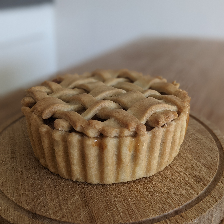

In [170]:
tf.keras.preprocessing.image.load_img(img_path, target_size = (IMG_HEIGHT, IMG_WIDTH))


In [171]:
def load_img_predict(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = (IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    img = np.expand_dims(img, axis = 0)
    
    return img

In [172]:
#classifier = classifier['MobileNetV2']
#classifier = classifier['VGG19']
clf_final.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 101)               103525    
Total params: 3,673,253
Trainable params: 1,415,269
Non-trainable params: 2,257,984
_________________________________________________________________


In [173]:
def predict_image(img_path,classifier):
    img = load_img_predict(img_path)
    res = clf_final.predict(img)

    res = sorted (
        list(zip ( 
            list(image_data_gen.class_indices.keys())
            , np.squeeze(res)
         )
        )
     , key=lambda x: x[1]   
     , reverse=True
    )
    
    return res

In [174]:
predict_image(img_path,clf_final)[:15]

[('apple_pie', 0.80408585),
 ('cup_cakes', 0.11340803),
 ('donuts', 0.033334356),
 ('baklava', 0.01887341),
 ('churros', 0.015212525),
 ('chocolate_cake', 0.004045012),
 ('carrot_cake', 0.0027939745),
 ('cheesecake', 0.0015421391),
 ('macarons', 0.0012604363),
 ('macaroni_and_cheese', 0.00053247757),
 ('dumplings', 0.00052628876),
 ('grilled_cheese_sandwich', 0.0004505205),
 ('tiramisu', 0.00040937297),
 ('red_velvet_cake', 0.0003911354),
 ('waffles', 0.00037280764)]

In [175]:
now_end = datetime.now()

end_notebook_time = now_end.strftime("%H:%M:%S")
print("End Notebook Time=", end_notebook_time)

diff2=((now_end - now1).total_seconds() )/ (60)
print("Time to run this notebook (minutes): ", diff2)


End Notebook Time= 15:13:57
Time to run this notebook (minutes):  247.17395663333335


In [176]:
print("Number of classes used in dataset:", subset)

Number of classes used in dataset: 102
